In [9]:
import requests
import zipfile
import io
import polars as pl

In [10]:
df_book_trades = pl.read_csv('BTCUSD_PERP-bookTicker-2024-10.csv')
df_book_trades

update_id,best_bid_price,best_bid_qty,best_ask_price,best_ask_qty,transaction_time,event_time
i64,f64,f64,f64,f64,i64,i64
1040037694559,63285.8,11.0,63285.9,4555.0,1727740800014,1727740800031
1040037723920,63285.8,11.0,63285.9,4563.0,1727740800114,1727740800170
1040037787516,63285.8,11.0,63285.9,4569.0,1727740800270,1727740800400
1040037787522,63285.8,2.0,63285.9,4569.0,1727740800270,1727740800400
1040037787543,63285.8,77.0,63285.9,4569.0,1727740800270,1727740800400
…,…,…,…,…,…,…
1049735799107,63880.5,4743.0,63880.6,176.0,1728885854968,1728885854977
1049735800034,63880.5,4793.0,63880.6,176.0,1728885855113,1728885855123
1049735800196,63880.5,4793.0,63880.6,177.0,1728885855128,1728885855132


In [13]:
import polars as pl
import numpy as np

# Correction de l'étape 1
df_book = (
    df_book_trades  # Assurez-vous d'utiliser votre variable source (df_booktrades vs df_book_trades)
    .with_columns([
        # On spécifie explicitement que l'input est en millisecondes
        pl.from_epoch(pl.col("transaction_time"), time_unit="ms").alias("datetime"),
        
        # Calcul du Mid Price
        ((pl.col("best_bid_price") + pl.col("best_ask_price")) / 2).alias("mid_price")
    ])
    .sort("datetime")
)

# Correction de l'étape 2 (Resampling)
df_resampled = (
    df_book
    .group_by_dynamic("datetime", every="1s") 
    .agg([
        pl.col("mid_price").first().alias("open"),
        pl.col("mid_price").max().alias("high"),
        pl.col("mid_price").min().alias("low"),
        pl.col("mid_price").last().alias("close"),
    ])
)

# Vérification : La shape doit être grande (ex: ~80k lignes pour un mois en 30s)
print(f"Nouvelle shape: {df_resampled.shape}")
print(df_resampled.head())

Nouvelle shape: (1134002, 5)
shape: (5, 5)
┌─────────────────────┬──────────┬──────────┬──────────┬──────────┐
│ datetime            ┆ open     ┆ high     ┆ low      ┆ close    │
│ ---                 ┆ ---      ┆ ---      ┆ ---      ┆ ---      │
│ datetime[ms]        ┆ f64      ┆ f64      ┆ f64      ┆ f64      │
╞═════════════════════╪══════════╪══════════╪══════════╪══════════╡
│ 2024-10-01 00:00:00 ┆ 63285.85 ┆ 63285.85 ┆ 63285.85 ┆ 63285.85 │
│ 2024-10-01 00:00:01 ┆ 63285.85 ┆ 63285.85 ┆ 63282.05 ┆ 63282.05 │
│ 2024-10-01 00:00:02 ┆ 63282.05 ┆ 63282.05 ┆ 63282.05 ┆ 63282.05 │
│ 2024-10-01 00:00:03 ┆ 63282.05 ┆ 63282.05 ┆ 63282.05 ┆ 63282.05 │
│ 2024-10-01 00:00:04 ┆ 63282.05 ┆ 63282.05 ┆ 63282.05 ┆ 63282.05 │
└─────────────────────┴──────────┴──────────┴──────────┴──────────┘


In [ ]:
import polars as pl
import matplotlib.pyplot as plt

print("="*70)
print("🔧 CALCUL CORRIGÉ DU SLIPPAGE")
print("="*70)


# Paramètres de filtrage
ASOF_TOLERANCE_MS = 100  # 🔑 TOLÉRANCE STRICTE: 100ms max entre trade et snapshot book
MAX_DISTANCE_TO_MID_BPS = 50  # 🔑 FILTRAGE: trades > 50 bps du mid sont suspects

# 1. Préparation des trades
df_trades_prep = (
    df_trades
    .with_columns([
        pl.from_epoch(pl.col("transact_time"), time_unit="ms").alias("trade_time"),
        pl.col("price").alias("trade_price"),
        pl.col("quantity").alias("trade_qty"),
        pl.col("is_buyer_maker").alias("seller_is_taker"),
    ])
    .sort("trade_time")
)

# 2. Join asof avec le book + TOLÉRANCE STRICTE
df_book_for_join = (
    df_book
    .select(["datetime", "mid_price", "best_bid_price", "best_ask_price"])
    .sort("datetime")
)

# 🔑 Utilisation de la syntaxe string pour la tolérance (plus compatible)
df_trades_with_book = (
    df_trades_prep
    .join_asof(
        df_book_for_join,
        left_on="trade_time",
        right_on="datetime",
        strategy="backward",
        tolerance=f"{ASOF_TOLERANCE_MS}ms",  # 🔑 CORRECTION: syntaxe string
    )
    .filter(pl.col("datetime").is_not_null())
)

trades_initial = len(df_trades_prep)
trades_matched = len(df_trades_with_book)
print(f"\n📊 Join asof avec tolérance de {ASOF_TOLERANCE_MS}ms:")
print(f"   Trades initiaux : {trades_initial:,}")
print(f"   Trades matchés  : {trades_matched:,}")
print(f"   Taux de match   : {trades_matched/trades_initial*100:.2f}%")

# 3. Calcul du slippage + distance au mid
df_slippage_raw = (
    df_trades_with_book
    .with_columns([
        ((pl.col("best_ask_price") - pl.col("best_bid_price")) / pl.col("mid_price") * 10000).alias("spread_bps"),
        
        # Slippage vs best bid/ask
        pl.when(pl.col("seller_is_taker"))
          .then((pl.col("best_bid_price") - pl.col("trade_price")) / pl.col("best_bid_price") * 10000)
          .otherwise((pl.col("trade_price") - pl.col("best_ask_price")) / pl.col("best_ask_price") * 10000)
          .alias("slippage_bps"),
        
        # 🔑 Distance au mid (pour filtrage robuste)
        ((pl.col("trade_price") - pl.col("mid_price")).abs() / pl.col("mid_price") * 10000).alias("dist_to_mid_bps"),
    ])
    .filter(pl.col("mid_price") > 0)
    .filter(pl.col("trade_price") > 0)
)

# 4. Diagnostic: Vérifier la cohérence des données
print(f"\n🔍 Diagnostic de cohérence:")
coherence = df_slippage_raw.select([
    pl.col("dist_to_mid_bps").mean().alias("avg_dist_mid"),
    pl.col("dist_to_mid_bps").quantile(0.95).alias("p95_dist_mid"),
    ((pl.col("trade_price") >= pl.col("best_bid_price")) & 
     (pl.col("trade_price") <= pl.col("best_ask_price"))).mean().alias("pct_inside_spread"),
]).to_pandas().iloc[0]

print(f"   Distance moyenne au mid  : {coherence['avg_dist_mid']:.2f} bps")
print(f"   Distance P95 au mid      : {coherence['p95_dist_mid']:.2f} bps")
print(f"   % trades dans le spread  : {coherence['pct_inside_spread']*100:.2f}%")

# 5. Filtrage robuste basé sur la distance au mid
df_slippage_filtered = (
    df_slippage_raw
    .filter(pl.col("dist_to_mid_bps") <= MAX_DISTANCE_TO_MID_BPS)  # 🔑 CORRECTION!
)

trades_filtered = len(df_slippage_raw)
trades_kept = len(df_slippage_filtered)
trades_removed = trades_filtered - trades_kept

print(f"\n🗑️ Filtrage des trades suspects (> {MAX_DISTANCE_TO_MID_BPS} bps du mid):")
print(f"   Avant filtrage  : {trades_filtered:,}")
print(f"   Après filtrage  : {trades_kept:,}")
print(f"   Retirés         : {trades_removed:,} ({trades_removed/trades_filtered*100:.2f}%)")

# 6. Statistiques globales (après filtrage)
slippage_stats = df_slippage_filtered.select([
    pl.col("slippage_bps").mean().alias("mean"),
    pl.col("slippage_bps").median().alias("median"),
    pl.col("slippage_bps").std().alias("std"),
    pl.col("slippage_bps").quantile(0.10).alias("p10"),
    pl.col("slippage_bps").quantile(0.25).alias("p25"),
    pl.col("slippage_bps").quantile(0.50).alias("p50"),
    pl.col("slippage_bps").quantile(0.75).alias("p75"),
    pl.col("slippage_bps").quantile(0.90).alias("p90"),
    pl.col("slippage_bps").quantile(0.95).alias("p95"),
    pl.col("spread_bps").mean().alias("avg_spread"),
]).to_pandas().iloc[0]

print("\n" + "="*70)
print("📈 RÉSULTATS - Analyse du slippage (taker vs best bid/ask)")
print("="*70)

print(f"\nSpread moyen du marché : {slippage_stats['avg_spread']:.4f} bps")

print("\nSlippage réel (bps) - Données nettoyées :")
print(f"   Moyenne     : {slippage_stats['mean']:.4f}")
print(f"   Médiane     : {slippage_stats['median']:.4f}")
print(f"   Écart-type  : {slippage_stats['std']:.4f}")
print(f"   P10         : {slippage_stats['p10']:.4f}")
print(f"   P25         : {slippage_stats['p25']:.4f}")
print(f"   P75         : {slippage_stats['p75']:.4f}")
print(f"   P90         : {slippage_stats['p90']:.4f}")
print(f"   P95         : {slippage_stats['p95']:.4f}")

# 7. Analyse par taille d'ordre (market impact)
quantiles = [0.25, 0.5, 0.75, 0.9, 0.95, 0.99]

size_quantiles = [
    df_slippage_filtered.select(pl.col("trade_qty").quantile(q)).item()
    for q in quantiles
]

print("\nDistribution des tailles de trades (unités) :")
print(f"   P25: {size_quantiles[0]:.2f} | "
      f"P50: {size_quantiles[1]:.2f} | "
      f"P75: {size_quantiles[2]:.2f}")
print(f"   P90: {size_quantiles[3]:.2f} | "
      f"P95: {size_quantiles[4]:.2f} | "
      f"P99: {size_quantiles[5]:.2f}")

df_by_size = (
    df_slippage_filtered
    .with_columns([
        pl.when(pl.col("trade_qty") <= size_quantiles[0]).then(pl.lit("1_tiny"))
          .when(pl.col("trade_qty") <= size_quantiles[1]).then(pl.lit("2_small"))
          .when(pl.col("trade_qty") <= size_quantiles[2]).then(pl.lit("3_medium"))
          .when(pl.col("trade_qty") <= size_quantiles[3]).then(pl.lit("4_large"))
          .when(pl.col("trade_qty") <= size_quantiles[4]).then(pl.lit("5_xlarge"))
          .otherwise(pl.lit("6_whale"))
          .alias("size_bucket")
    ])
    .group_by("size_bucket")
    .agg([
        pl.len().alias("n_trades"),
        pl.col("trade_qty").mean().alias("avg_qty"),
        pl.col("slippage_bps").mean().alias("avg_slip"),
        pl.col("slippage_bps").median().alias("median_slip"),
        pl.col("slippage_bps").quantile(0.75).alias("p75_slip"),
        pl.col("slippage_bps").quantile(0.95).alias("p95_slip"),
    ])
    .sort("size_bucket")
)

print("\nSlippage par taille d'ordre :")
print(df_by_size.to_pandas().to_string(index=False))

# 8. Calibration finale
print("\n" + "="*70)
print("🎯 CALIBRATION FINALE")
print("="*70)

# Utiliser le P75 comme estimateur robuste
SLIPPAGE_CALIBRATED_BPS = slippage_stats['p75']
SLIPPAGE_CALIBRATED = SLIPPAGE_CALIBRATED_BPS / 10000

# Par taille
small_trades = df_slippage_filtered.filter(pl.col("trade_qty") <= size_quantiles[2])
SLIPPAGE_SMALL_BPS = small_trades.select(pl.col("slippage_bps").quantile(0.75)).item()

large_trades = df_slippage_filtered.filter(pl.col("trade_qty") > size_quantiles[3])
SLIPPAGE_LARGE_BPS = large_trades.select(pl.col("slippage_bps").quantile(0.75)).item()

print(f"\nSlippage recommandé (P75, en bps) :")
print(f"   Petits ordres (≤ P75) : {SLIPPAGE_SMALL_BPS:.3f} bps")
print(f"   Tous ordres (global)  : {SLIPPAGE_CALIBRATED_BPS:.3f} bps  ⭐")
print(f"   Gros ordres (> P90)   : {SLIPPAGE_LARGE_BPS:.3f} bps")

print(f"\n✅ Slippage calibré : {SLIPPAGE_CALIBRATED_BPS:.4f} bps ({SLIPPAGE_CALIBRATED*100:.6f}%)")

# Vérification de cohérence
if SLIPPAGE_CALIBRATED_BPS > slippage_stats['avg_spread'] * 100:
    print(f"\n⚠️ ATTENTION: Le slippage ({SLIPPAGE_CALIBRATED_BPS:.2f} bps) est {SLIPPAGE_CALIBRATED_BPS/slippage_stats['avg_spread']:.0f}x plus grand que le spread!")
    print("   Cela suggère un problème de market impact important ou des données agrégées.")
elif SLIPPAGE_CALIBRATED_BPS > slippage_stats['avg_spread'] * 10:
    print(f"\n⚠️ Le slippage est {SLIPPAGE_CALIBRATED_BPS/slippage_stats['avg_spread']:.1f}x le spread moyen.")
    print("   Normal pour des ordres taker avec market impact.")
else:
    print(f"\n✅ Le slippage ({SLIPPAGE_CALIBRATED_BPS:.2f} bps) est cohérent avec le spread ({slippage_stats['avg_spread']:.2f} bps).")

AS Pragmatique: gamma=0.01, limit=±10, spread_mult=1.5


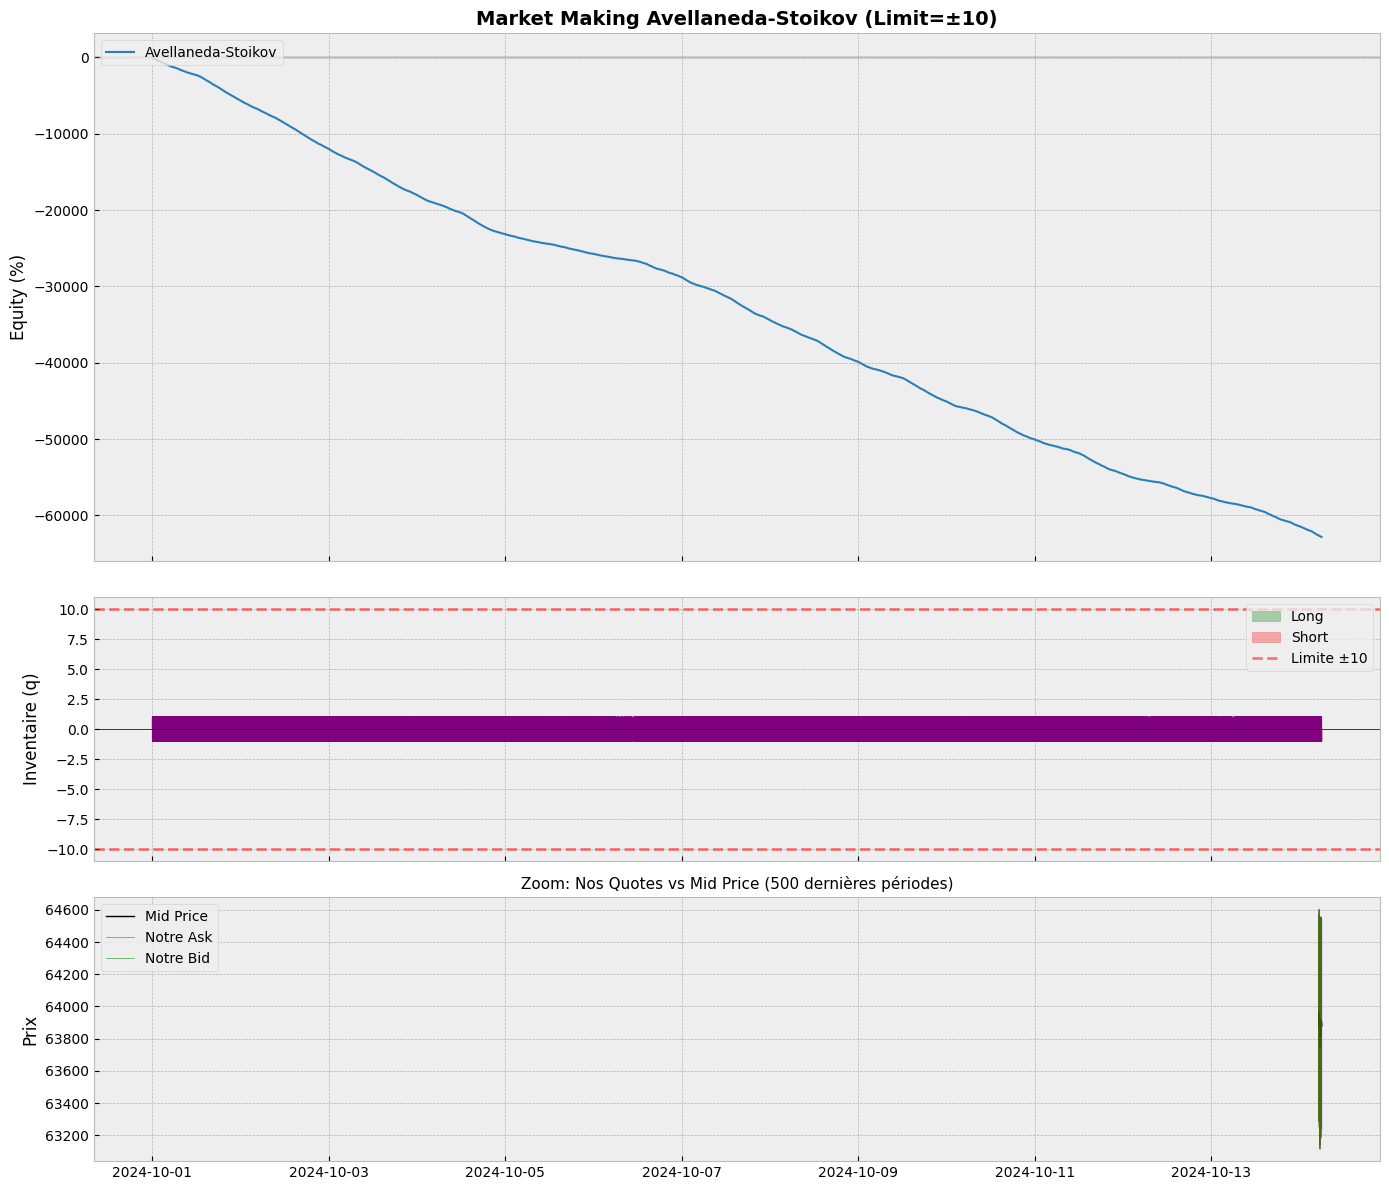

RÉSULTATS AVELLANEDA-STOIKOV
Equity Finale      : -62809.22%
Inventaire Final   : 0
Spread Capturé     : $902.40
Max Inventaire     : 1
Min Inventaire     : -1


In [14]:
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick

# ============================================================================
# STRATÉGIE AVELLANEDA-STOIKOV (Version Réaliste)
# ============================================================================
# 
# Problème de la version précédente : 
# - Spread optimal trop large (formule mal calibrée pour données 5s)
# - Pas de limite d'inventaire
# - Volatilité sigma trop petite (non annualisée)
#
# Cette version utilise une approche pragmatique :
# - Spread basé sur le spread réel du marché (plus réaliste)
# - Skew basé sur l'inventaire (le coeur d'AS)
# - Limite d'inventaire stricte
# ============================================================================

# --- PARAMÈTRES ---
GAMMA = 0.01              # Sensibilité à l'inventaire (skew)
INVENTORY_LIMIT = 10      # Position max autorisée (+/-)
SPREAD_MULT = 1.5         # Multiplicateur du spread marché (on quote légèrement plus large)

def prepare_data_as(df_book):
    """Prépare les données avec OHLC et spread réel du marché."""
    df = (
        df_book
        .group_by_dynamic("datetime", every="5s")
        .agg([
            pl.col("mid_price").first().alias("open"),
            pl.col("mid_price").max().alias("high"),
            pl.col("mid_price").min().alias("low"),
            pl.col("mid_price").last().alias("close"),
            pl.col("best_ask_price").last().alias("ask_close"),
            pl.col("best_bid_price").last().alias("bid_close"),
        ])
        .with_columns([
            # Spread réel du marché (en valeur absolue, pas en %)
            (pl.col("ask_close") - pl.col("bid_close")).alias("market_spread"),
            # Volatilité roulante (pour info/debug)
            pl.col("close").log().diff().rolling_std(window_size=100).fill_null(0.0001).alias("sigma")
        ])
    )
    return df


def run_hft_AS(df_input, gamma=GAMMA, inv_limit=INVENTORY_LIMIT, spread_mult=SPREAD_MULT):
    """
    Stratégie Avellaneda-Stoikov pragmatique.
    
    Logique :
    1. On quote autour du mid avec un spread = spread_marché * multiplicateur
    2. On SKEW nos prix en fonction de l'inventaire :
       - Si Long (q>0)  → on baisse nos prix pour vendre
       - Si Short (q<0) → on monte nos prix pour acheter
    3. Si on atteint la limite d'inventaire, on ne quote plus du côté dangereux
    """
    print(f"AS Pragmatique: gamma={gamma}, limit=±{inv_limit}, spread_mult={spread_mult}")
    
    df = df_input.to_pandas()
    n = len(df)
    
    mid_prices = df['close'].values
    highs = df['high'].values
    lows = df['low'].values
    market_spreads = df['market_spread'].values
    
    # États
    inventory = np.zeros(n)
    cash = np.zeros(n)
    pnl_spread = np.zeros(n)  # PnL provenant du spread capturé
    
    q = 0.0
    c = 0.0
    spread_captured = 0.0
    
    # Pour visualisation
    our_bids = np.zeros(n)
    our_asks = np.zeros(n)
    
    for t in range(1, n):
        s = mid_prices[t-1]
        mkt_spread = market_spreads[t-1]
        if mkt_spread <= 0: 
            mkt_spread = 0.1  # Spread minimum
        
        # --- 1. Calcul de nos prix ---
        half_spread = (mkt_spread * spread_mult) / 2
        
        # Skew basé sur l'inventaire (coeur d'AS)
        # Plus on est Long, plus on décale vers le bas pour vendre
        # Plus on est Short, plus on décale vers le haut pour acheter
        skew = q * gamma * s  # Skew proportionnel au prix et à l'inventaire
        
        our_ask = s + half_spread - skew  # Si Long (q>0), skew>0, ask baisse
        our_bid = s - half_spread - skew  # Si Long (q>0), skew>0, bid baisse aussi
        
        our_asks[t] = our_ask
        our_bids[t] = our_bid
        
        # --- 2. Limite d'inventaire ---
        post_bid = (q < inv_limit)   # On peut encore acheter ?
        post_ask = (q > -inv_limit)  # On peut encore vendre ?
        
        # --- 3. Vérification des exécutions ---
        executed_buy = False
        executed_sell = False
        
        # Achat si le Low du marché descend à notre Bid
        if post_bid and lows[t] <= our_bid:
            executed_buy = True
            
        # Vente si le High du marché monte à notre Ask
        if post_ask and highs[t] >= our_ask:
            executed_sell = True
        
        # --- 4. Mise à jour des positions ---
        if executed_buy and executed_sell:
            # Round-trip complet dans la bougie → on capture le spread
            spread_captured += (our_ask - our_bid)
            c += (our_ask - our_bid)
            # q inchangé
        elif executed_buy:
            q += 1
            c -= our_bid
        elif executed_sell:
            q -= 1
            c += our_ask
            
        inventory[t] = q
        cash[t] = c
        pnl_spread[t] = spread_captured
    
    # --- Résultats ---
    df['inventory'] = inventory
    df['cash'] = cash
    df['our_bid'] = our_bids
    df['our_ask'] = our_asks
    
    # Mark-to-Market
    df['market_value'] = df['inventory'] * df['close']
    df['total_equity'] = df['cash'] + df['market_value']
    
    # Performance en %
    initial_capital = df['close'].iloc[0]  # On part avec l'équivalent de 1 unité
    df['equity_pct'] = (df['total_equity'] / initial_capital) * 100
    df['pnl_spread'] = pnl_spread
    
    return pl.from_pandas(df)


# ============================================================================
# EXÉCUTION
# ============================================================================

if 'df_book' in locals():
    # Préparation
    df_as_input = prepare_data_as(df_book)
    
    # Run
    df_results = run_hft_AS(df_as_input)
    pdf = df_results.to_pandas()
    
    # Métriques
    final_equity = pdf['total_equity'].iloc[-1]
    final_inventory = pdf['inventory'].iloc[-1]
    final_pnl_spread = pdf['pnl_spread'].iloc[-1]
    
    # Buy & Hold pour comparaison
    pdf['bnh_pct'] = (pdf['close'] / pdf['close'].iloc[0] - 1) * 100
    
    # ========== GRAPHIQUES ==========
    plt.style.use('bmh')
    fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True, 
                              gridspec_kw={'height_ratios': [3, 1.5, 1.5]})
    
    # 1. Performance
    ax1 = axes[0]
    ax1.plot(pdf['datetime'], pdf['equity_pct'], label='Avellaneda-Stoikov', color='#2980b9', linewidth=1.5)
    ax1.axhline(0, color='gray', linestyle='-', alpha=0.3)
    ax1.set_title(f'Market Making Avellaneda-Stoikov (Limit=±{INVENTORY_LIMIT})', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Equity (%)')
    ax1.legend(loc='upper left')
    
    # 2. Inventaire
    ax2 = axes[1]
    ax2.fill_between(pdf['datetime'], pdf['inventory'], 0, 
                     where=(pdf['inventory'] >= 0), color='green', alpha=0.3, label='Long')
    ax2.fill_between(pdf['datetime'], pdf['inventory'], 0, 
                     where=(pdf['inventory'] < 0), color='red', alpha=0.3, label='Short')
    ax2.plot(pdf['datetime'], pdf['inventory'], color='purple', linewidth=0.8)
    ax2.axhline(INVENTORY_LIMIT, color='red', linestyle='--', alpha=0.5, label=f'Limite ±{INVENTORY_LIMIT}')
    ax2.axhline(-INVENTORY_LIMIT, color='red', linestyle='--', alpha=0.5)
    ax2.axhline(0, color='black', linewidth=0.5)
    ax2.set_ylabel('Inventaire (q)')
    ax2.legend(loc='upper right')
    
    # 3. Zoom sur les quotes (dernières 500 périodes)
    ax3 = axes[2]
    zoom_start = max(0, len(pdf) - 500)
    pdf_zoom = pdf.iloc[zoom_start:]
    
    ax3.plot(pdf_zoom['datetime'], pdf_zoom['close'], label='Mid Price', color='black', linewidth=1)
    ax3.plot(pdf_zoom['datetime'], pdf_zoom['our_ask'], label='Notre Ask', color='red', linewidth=0.5, alpha=0.7)
    ax3.plot(pdf_zoom['datetime'], pdf_zoom['our_bid'], label='Notre Bid', color='green', linewidth=0.5, alpha=0.7)
    ax3.fill_between(pdf_zoom['datetime'], pdf_zoom['our_bid'], pdf_zoom['our_ask'], alpha=0.1, color='blue')
    ax3.set_title('Zoom: Nos Quotes vs Mid Price (500 dernières périodes)', fontsize=11)
    ax3.set_ylabel('Prix')
    ax3.legend(loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    # Stats finales
    print("=" * 50)
    print("RÉSULTATS AVELLANEDA-STOIKOV")
    print("=" * 50)
    print(f"Equity Finale      : {pdf['equity_pct'].iloc[-1]:.2f}%")
    print(f"Inventaire Final   : {final_inventory:.0f}")
    print(f"Spread Capturé     : ${final_pnl_spread:.2f}")
    print(f"Max Inventaire     : {pdf['inventory'].max():.0f}")
    print(f"Min Inventaire     : {pdf['inventory'].min():.0f}")
    
else:
    print("⚠️ df_book manquant. Exécutez les cellules précédentes.")